In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL
from mac0460_5832.utils import *


########################################################################
#
# Classes                                                       
#
###
# WOperator Learner Class
class WOperatorLearner:
    """ Class used to learn a biniary image operator """
    
    def __init__ (self, n, m, mask=[]):
        """ Class constructor """
        self.window_shape = (n, m)
        self.samples = {}
        self._update_hypothesis ()
        self.mask = list (mask)
        if not self.mask:
            for i in range (n):
                self.mask.append ([])
                for j in range (m):
                    self.mask[i].append (1)
        self.mask = np.array (self.mask)

        
    def sample_image (self, src, dest):
        """ Samples an image, adding samples to the self.samples
        hash """
        x_offset = int ((self.window_shape[1] - 1) / 2)
        y_offset = int ((self.window_shape[0] - 1) / 2)
        bsrc = zero_border_img (src, x_offset, y_offset)
        window_configuration = []
        sy, ey = 0, 2 * y_offset + 1
        
        for i in range (src.shape[0]):
            sx, ex = 0, 2 * x_offset + 1
            for j in range (src.shape[1]):
                window = bsrc[sy:ey, sx:ex]
                window = np.multiply (window, self.mask)
                w_int = window_to_int (window, 2)
                label = dest[i][j]
                if (w_int not in self.samples):
                    self.samples[w_int] = [0, 0]
                self.samples[w_int][label] += 1
                sx += 1
                ex += 1
            sy += 1
            ey += 1
        self._update_hypothesis ()


    def get_window_shape (self):
        return self.window_shape
    
    
    def get_hypothesis (self):
        ''' Returns a hash containing that represents the hypothesis '''
        return self.hypothesis


    def get_samples (self):
        ''' Returns samples hash '''
        return self.samples


    def _update_hypothesis (self):
        ''' Creates the hypothesis hash '''
        self.hypothesis = {}
        h = self.hypothesis
        n = self.window_shape[0]
        m = self.window_shape[1]
        for w in self.samples:
            l = self.samples[w][0] < self.samples[w][1]
            h[w] = l
    
    def clean_samples (self):
        ''' Cleans hash of samples and hypothesis '''
        self.samples = {}
        self._update_hypothesis ()
                
# End of WOperatorLearner Class
##


########################################################################


###
# Multiresolution WOperator Learner Class
#
class Multiresolution:
    """ Class used to learn a binary image operator using 
    Multiresolution. """
            
            
    def __init__ (self, wol_list):
        """ Class constructor. """
        self.wol_list = wol_list
        self.sample_list = []
        self.lookup_table = {}
        self.window_shape = wol_list[0].get_window_shape ()
        
    
    def sample_image (self, src, dest):
        """ Samples an image, on each leavel of the multiresolution
        pyramid, and stores them at the sample_list array. """
        self.sample_list = []
        for learner in self.wol_list:
            learner.sample_image (src, dest)
        self.sample_list = []
        for i in range (0, len (self.wol_list)):
            self.sample_list.append (self.wol_list[i].get_samples ())


    def get_samples (self):
        """ Returns an array that store the samples of each level of
        the pyramid. """
        return self.sample_list

    
    def classify_window (self, window):
        """ Given a window, returns the label of that window, using the 
        multiresolution approach. """
        w_int = window_to_int (window, 2)
        i = 0
        while (i < len (self.sample_list)):
            samples = self.sample_list[i]
            if (w_int in samples):
                answ = samples[w_int][0] < samples[w_int][1]
                return answ
            i += 1
        return False
    
    
    def operate_image (self, img):
        """ Operates over an image. """
        x_border = (self.window_shape[1] - 1) // 2
        y_border = (self.window_shape[0] - 1) // 2
        bimg = zero_border_img (img, x_border, y_border)
        dest = np.copy (img)
        sy, ey = 0, self.window_shape[0]
        
        for i in range (img.shape[0]):
            sx, ex = 0, self.window_shape[1]
            for j in range (img.shape[1]):
                window = bimg[sy:ey, sx:ex]
                y = self.classify_window (window)
                dest[i][j] = y
                sx += 1
                ex += 1
            sy += 1
            ey += 1
            
        return dest
        
    def clean_samples (self):
        self.samples = {}
        
# End of Multiresolution Class
##

########################################################################
#
# General Use Functions                                                   
#
###
def window_to_int (window, base):
    """ Maps a window to an integer. The way this function works is
    reading the window as a number of base <base> from left to right
    and up to down. It returns the same number in base 10 """
    total = 0
    power = 1
    w = window.tolist ()
    for row in w:
        for element in row:
            total += element * power
            power *= base
    return int (total)


def int_to_window (number, base, shape):
    """ The inverse of window_to_int """
    power = 1
    window_size = shape[0] * shape[1]
    w_arr = []
    while (number > 0):
        d = number % base
        number = number // base
        w_arr.append (d)
    while (len (w_arr) < window_size):
        w_arr.append (0)
    w = np.array ([w_arr])
    w.reshape (shape)
    return w


def zero_border_img (img, x_border, y_border):
    """ This function creates a border of zeros on img """
    h = img.shape[0]
    w = img.shape[1]
    new_h = h + 2 * y_border
    new_w = w + 2 * x_border
    zeros = np.zeros ((new_h, new_w))
    bordered_img = zeros
    y_start, y_end = y_border, -y_border
    x_start, x_end = x_border, -x_border
    if y_border is 0: y_end = h
    if x_border is 0: x_end = w
    bordered_img[y_start:y_end, x_start:x_end] += img
    return bordered_img


# calculates absolute difference of images img1 and img2
def abs_img_error (img1, img2):
    ''' Calculates absolute error of two binary images '''
    img_shape = img1.shape
    e = 0.0
    for i in range (img_shape[0]):
        for j in range (img_shape[1]):
            e += int (img1[i][j] != img2[i][j])
    return e


# Calculates wop error when operating image src_list
def wop_err (wop, src_list, dest_list):
    """ Calculates the error of a W-Operator """
    rel_err = 0.0
    img_shape = src_list[0].shape
    for i, img in enumerate (src_list):
        res = wop.operate_image (img)
        rel_err += abs_img_error (dest_list[i], res)
    rel_err /= (img_shape[0] * img_shape[1] * len (src_list))
    return rel_err


# Plots E_in and E_val
def plot_error (n, errors_list, labels_list):
    ax = plt.gca ()
    x = range (1, n + 1)
    for i, error_t in enumerate (errors_list):
        plt.plot (x, error_t, label = labels_list[i])    
    handlers, labels = ax.get_legend_handles_labels ()
    ax.legend (handlers, labels, loc = 'upper right', numpoints = 1)
    plt.ylabel ('Relative error')
    plt.xlabel ('Number of images sampled')
    plt.show ()
    plt.clf ()
    
    
# Given a set of size N, returns a random partition of this set
# containing two subsets of size N - k and k
def validation_partition (data_set, k):
    np.random.shuffle (data_set)
    return (data_set[k:], data_set[:k])

# MAC0460/5832 - Lista 2: Escolha de modelo

### Data de Entrega: 23h55m do dia 05/06/2017


Q1. Projete, a partir dos dados, o operador capaz de filtrar ruído usando a técnica de multiresolução. Como conjuntos de hipóteses, utilize diferentes subamostragens da janela original, como ilustrado abaixo:

1. Subamostragem 1: ![alt text](imgs/q1_h1.png "1")
2. Subamostragem 2: ![alt text](imgs/q1_h2.png "2")
3. Subamostragem 3: ![alt text](imgs/q1_h3.png "2")

Para cada conjunto, plote os erros  $E_{in}$ e $E_{val}$ ao longo do treinamento. Após escolher o modelo mais apropriado, retreine seu operador com todos os dados e imprima o erro $E_{in}$.

Utilize as imagens da pasta imgs/q1/ para realizar o treinamento e validação (nota: são as mesmas imagens do EP anterior).

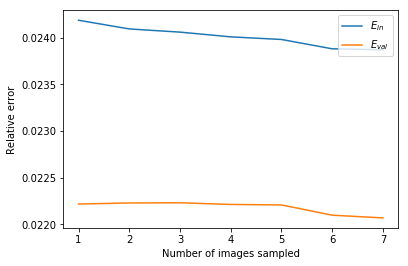

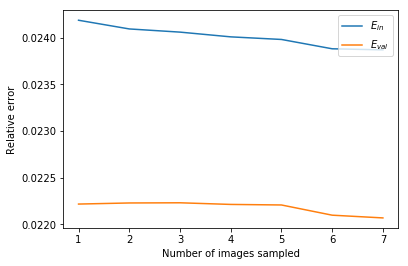

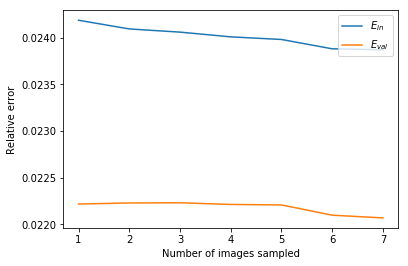

Best E_in on model validation: 0.02386886160714286
E_in of the chosen model: 0.02343359375


In [2]:
########################################################################
src1 = read_img ('imgs/q1/q1_src1.png')
src2 = read_img ('imgs/q1/q1_src2.png')
src3 = read_img ('imgs/q1/q1_src3.png')
src4 = read_img ('imgs/q1/q1_src4.png')
src5 = read_img ('imgs/q1/q1_src5.png')
src6 = read_img ('imgs/q1/q1_src6.png')
src7 = read_img ('imgs/q1/q1_src7.png')
src8 = read_img ('imgs/q1/q1_src8.png')
src9 = read_img ('imgs/q1/q1_src9.png')
dest1 = read_img ('imgs/q1/q1_dest.png')
src_list = [src1, src2, src3, src4, src5, src6, src7, src8, src9]
dest_list = [dest1, dest1, dest1, dest1, dest1, dest1, dest1, dest1,
             dest1]
validation_k = 2

training_set, validation_set = validation_partition (src_list,
                                                     validation_k)
training_set_size = len (training_set)
    
# Defines H1
h1_w2_mask = np.array ([[1, 0, 1, 0, 1],
                        [0, 0, 0, 0, 0],
                        [1, 0, 1, 0, 1],
                        [0, 0, 0, 0, 0],
                        [1, 0, 1, 0, 1]])
h1_w3_mask = np.array ([[0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0]])
h1_wol1 = WOperatorLearner (5, 5)
h1_wol2 = WOperatorLearner (5, 5, h1_w2_mask)
h1_wol3 = WOperatorLearner (5, 5, h1_w3_mask)
sub_sample1_wol_list = [h1_wol1, h1_wol2, h1_wol3]
sub_sample1_multires = Multiresolution (sub_sample1_wol_list)

# Traininig and error for H1
e1_in_t = []
e1_val_t = []
h1_e_in = 0
for img in training_set:
    sub_sample1_multires.sample_image (img, dest1)
    e_in = wop_err (sub_sample1_multires, training_set, dest_list)
    e_val = wop_err (sub_sample1_multires, validation_set, dest_list)
    e1_in_t.append (e_in)
    e1_val_t.append (e_val)
    h1_e_in = e_in
    
# Plots E_in and E_val
errors_list = []
labels_list = []
errors_list.append (e1_in_t)
errors_list.append (e1_val_t)
labels_list.append ('$E_{in}$')
labels_list.append ('$E_{val}$')
plot_error (training_set_size, errors_list, labels_list)


# Defines H2
h2_w2_mask = np.array ([[0, 0, 0, 0, 0],
                        [0, 1, 1, 1, 0],
                        [0, 1, 1, 1, 0],
                        [0, 1, 1, 1, 0],
                        [0, 0, 0, 0, 0]])
h2_w3_mask = np.array ([[0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0]])
h2_wol1 = WOperatorLearner (5, 5)
h2_wol2 = WOperatorLearner (5, 5, h2_w2_mask)
h2_wol3 = WOperatorLearner (5, 5, h2_w3_mask)
sub_sample2_wol_list = [h2_wol1, h2_wol2, h2_wol3]
sub_sample2_multires = Multiresolution (sub_sample2_wol_list)

# Traininig and error calculations for H2
e2_in_t = []
e2_val_t = []
h2_e_in = 0
for img in training_set:
    sub_sample2_multires.sample_image (img, dest1)
    e_in = wop_err (sub_sample2_multires, training_set, dest_list)
    e_val = wop_err (sub_sample2_multires, validation_set, dest_list)
    e2_in_t.append (e_in)
    e2_val_t.append (e_val)
    h2_e_in = e_in

# Plots E_in and E_val
errors_list = []
labels_list = []
errors_list.append (e2_in_t)
errors_list.append (e2_val_t)
labels_list.append ('$E_{in}$')
labels_list.append ('$E_{val}$')
plot_error (training_set_size, errors_list, labels_list)


# Defines H3
h3_w2_mask = np.array ([[0, 0, 1, 0, 0],
                        [0, 1, 1, 1, 0],
                        [1, 1, 1, 1, 1],
                        [0, 1, 1, 1, 0],
                        [0, 0, 1, 0, 0]])
h3_w3_mask = np.array ([[0, 0, 0, 0, 0],
                        [0, 0, 1, 0, 0],
                        [0, 1, 1, 1, 0],
                        [0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0]])
h3_w4_mask = np.array ([[0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0]])
h3_wol1 = WOperatorLearner (5, 5)
h3_wol2 = WOperatorLearner (5, 5, h3_w2_mask)
h3_wol3 = WOperatorLearner (5, 5, h3_w3_mask)
h3_wol4 = WOperatorLearner (5, 5, h3_w4_mask)
sub_sample3_wol_list = [h3_wol1, h3_wol2, h3_wol3, h3_wol4]
sub_sample3_multires = Multiresolution (sub_sample3_wol_list)

# Traininig and error for H3
e3_in_t = []
e3_val_t = []
h3_e_in = 0
for img in training_set:
    sub_sample3_multires.sample_image (img, dest1)
    e_in = wop_err (sub_sample3_multires, training_set, dest_list)
    e_val = wop_err (sub_sample3_multires, validation_set, dest_list)
    e3_in_t.append (e_in)
    e3_val_t.append (e_val)
    h3_e_in = e_in
    
# Plots E_in and E_val
errors_list = []
labels_list = []
errors_list.append (e3_in_t)
errors_list.append (e3_val_t)
labels_list.append ('$E_{in}$')
labels_list.append ('$E_{val}$')
plot_error (training_set_size, errors_list, labels_list)


# Finds best model and re-trains it with the whole data set
multires_list = [sub_sample1_multires,
                 sub_sample2_multires, 
                 sub_sample3_multires]
model_error_list = [h1_e_in, h2_e_in, h3_e_in]
i = np.argmin (model_error_list)
best_multires = multires_list[i]
print ("Best E_in on model validation: " + str (model_error_list[i]))
best_multires.clean_samples ()

training_set = src_list
training_set_size = len (training_set)
e_in_t = []
e_in = 0
for img in training_set:
    best_multires.sample_image (img, dest1)
    e_in = wop_err (best_multires, training_set, dest_list)
    e3_in_t.append (e_in)
print ("E_in of the chosen model: " + str (e_in))

Q2. Considere novamente o problema de filtrar ruído. Utilizando as imagens da pasta imgs/q2/, explore diferentes
funções booleanas para filtrar ruído. A operação **abertura** é definida como uma **erosão** seguida por uma **dilatação**, isto é $\delta_{B2}\epsilon_{B1}$, onde $B1$ e $B2$ são os elementos estruturantes. De modo semelhante, a função **fechamento** é definida por uma **dilatação** seguida por uma **erosão** ($\epsilon_{B2}\delta_{B1}$). Baseado nas funções *erosion* e *dilation* definidas em mac0460_5832/utils.py, teste os seguintes espaços de hipóteses:

1. Abertura;
2. Fechamento;
3. Abertura seguida de fechamento;

Para cada espaço de hipóteses, defina diferentes funções variando $B1$ e $B2$ (ou seja, crie as funções de maneira análoga à seguinte definição para um conjunto de aberturas: $\mathcal{F} = \{\psi_{B1B2}: \psi =  \delta_{B2}\epsilon_{B1}, B1, B2 \subseteq W_{3x3} \}$, onde $W_{3x3}$ é a janela 3x3). Mostre a função que tem menor erro e verifique o seu desempenho nos dados de teste.

Obs: existe no utils.py funções para abertura e fechamento. No entanto, essas funções utilizam o mesmo elemento estruturante para a erosão e dilatação, não permitindo o uso de diferentes elementos estruturantes. 

In [ ]:
# Exemplo 
draw_img_pair(read_img('imgs/q2/dest.png'), read_img('imgs/q2/src0.png'), figsz=(11, 3.5))